The numba jit compiler can also use the GPU CUDA instead of the CPU!


Information here is adapted from Nvidia's [Numba for CUDA](https://github.com/numba/nvidia-cuda-tutorial),  [New York University](https://nyu-cds.github.io/python-numba/05-cuda/) and [Microway](https://www.microway.com/hpc-tech-tips/cuda-parallel-thread-management/) resources.

# CUDA
CUDA is a software layer that gives direct access to the GPU's virtual instruction set and parallel computational elements for the execution of compute kernels.

# Writing CUDA kernels

CUDA has an execution model unlike the traditional sequential model used for programming CPUs. In CUDA, the code you write will be executed by multiple threads at once (often hundreds or thousands). Your solution will be modeled by defining a thread hierarchy of grid, blocks, and threads.

# CUDA Threads
CUDA threads utilize block and thread IDs to determine what data to compute. Block IDs can be 1D or 2D. Thread IDs can be 1D, 2D, or 3D. Utilizing multidimensional threads and blocks greatly simplifies memory addressing when performing operations on multidimensional data (a very common occurrence in image processing, for example). You, the programmer, declare the size of the block (between 1 and 512 concurrent threads), the number of dimensions (1D, 2D, 3D) of the block, and the block dimensions in threads. In each block, all of the threads are capable of sharing data and synchronizing. The image below depicts the CUDA grid/block/thread structure.

![picture](https://www.microway.com/wp-content/uploads/CUDA-GridBlockThread-Structure.png)

Numba also exposes three kinds of GPU memory:

* global device memory
* shared memory
* local memory

For all but the simplest algorithms, it is important that you carefully consider how to use and access memory in order to minimize bandwidth requirements and contention.

NVIDIA recommends that programmers focus on following those recommendations to achieve the best performance:

* Find ways to parallelize sequential code
* Minimize data transfers between the host and the device
* Adjust kernel launch configuration to maximize device utilization
* Ensure global memory accesses are coalesced
* Minimize redundant accesses to global memory whenever possible
* Avoid different execution paths within the same warp

# Kernel declaration

A kernel function is a GPU function that is meant to be called from CPU code. It has two fundamental characteristics:

* kernels cannot explicitly return a value; all result data must be written to an array passed to the function (if computing a scalar, you will probably pass a one-element array);
* kernels explicitly declare their thread hierarchy when called: i.e. the number of thread blocks and the number of threads per block (note that while a kernel is compiled once, it can be called multiple times with different block sizes or grid sizes).



```
from numba import cuda

@cuda.jit
def my_kernel(io_array):
    """
    Code for kernel.
    """
    # code here
```



# Kernel invocation

For memory size choice read more here: https://nyu-cds.github.io/python-numba/05-cuda/

Pay attention to *Choosing the block size* and *Thread positioning* sections.




In [1]:
# non-GPU version
import numpy as np
import time

np.random.seed(seed=71830)

def multiply_on_cpu(A, B):
    return np.dot(A, B)


# Example usage
matrix_size = 128
A = np.random.random((matrix_size, matrix_size))
B = np.random.random((matrix_size, matrix_size))

# Measure the time taken for CPU multiplication
start_time_cpu = time.time()
result_cpu = multiply_on_cpu(A, B)
end_time_cpu = time.time()

print("Result from CPU:\n", result_cpu.shape)

Result from CPU:
 (128, 128)


In [2]:
from numba import cuda
import numpy as np

# CUDA kernel function
@cuda.jit
def multiply_kernel(A, B, result):
    i, j = cuda.grid(2)
    if i < result.shape[0] and j < result.shape[1]:
        temp = 0.0
        for k in range(A.shape[1]):
            temp += A[i, k] * B[k, j]
        result[i, j] = temp

# Host function to launch the kernel
def multiply_on_gpu(A, B):
    # Allocate device memory
    d_A = cuda.to_device(A)
    d_B = cuda.to_device(B)
    result = cuda.device_array_like(A)  # Allocate device memory for the result

    # Define the grid and block dimensions
    threadsperblock = (32, 32)
    blockspergrid_x = (A.shape[0] + threadsperblock[0] - 1) // threadsperblock[0]
    blockspergrid_y = (A.shape[1] + threadsperblock[1] - 1) // threadsperblock[1]
    blockspergrid = (blockspergrid_x, blockspergrid_y)

    # Launch the kernel on the GPU
    multiply_kernel[blockspergrid, threadsperblock](d_A, d_B, result)

    # Copy the result back to the host
    cuda.synchronize()
    result_host = result.copy_to_host()

    return result_host

# Example usage
A = np.random.random((matrix_size, matrix_size))
B = np.random.random((matrix_size, matrix_size))

start_time_gpu = time.time()
result_gpu = multiply_on_gpu(A, B)
end_time_gpu = time.time()
print("Result from GPU:\n", result_gpu)

# Verify the result with CPU multiplication
result_cpu = multiply_on_cpu(A, B)
print("Result from CPU:\n", result_cpu)

# Check if the results match
print("Results match:", np.allclose(result_cpu, result_gpu))

/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 16 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


Result from GPU:
 [[29.17036183 29.69913167 27.65780502 ... 28.12225965 23.23362585
  30.36152732]
 [31.4453704  28.84866207 29.85955084 ... 28.72732914 25.11381147
  29.61976377]
 [33.47101686 33.18234301 31.78830739 ... 32.46687867 27.84503191
  34.36742248]
 ...
 [33.07834453 34.02876537 33.24415391 ... 32.65167384 28.73960337
  34.31555131]
 [32.81671896 31.96341855 32.22368106 ... 30.61800854 26.00606952
  32.49082893]
 [35.26462224 33.39155538 32.41981669 ... 31.85037933 28.87724287
  34.87878188]]
Result from CPU:
 [[29.17036183 29.69913167 27.65780502 ... 28.12225965 23.23362585
  30.36152732]
 [31.4453704  28.84866207 29.85955084 ... 28.72732914 25.11381147
  29.61976377]
 [33.47101686 33.18234301 31.78830739 ... 32.46687867 27.84503191
  34.36742248]
 ...
 [33.07834453 34.02876537 33.24415391 ... 32.65167384 28.73960337
  34.31555131]
 [32.81671896 31.96341855 32.22368106 ... 30.61800854 26.00606952
  32.49082893]
 [35.26462224 33.39155538 32.41981669 ... 31.85037933 28.87724

In [3]:
print("CPU Time:", end_time_cpu - start_time_cpu, "seconds")
print("GPU Time:", end_time_gpu - start_time_gpu, "seconds")

CPU Time: 0.0011682510375976562 seconds
GPU Time: 0.43275904655456543 seconds


In [4]:
start_time_gpu = time.time()
result_gpu = multiply_on_gpu(A, B)
end_time_gpu = time.time()
print("GPU Time without compilation:", end_time_gpu - start_time_gpu, "seconds")

GPU Time without compilation: 0.002741575241088867 seconds


1
2
4
8
16
32
64
128
256
512
1024
2048
4096
8192


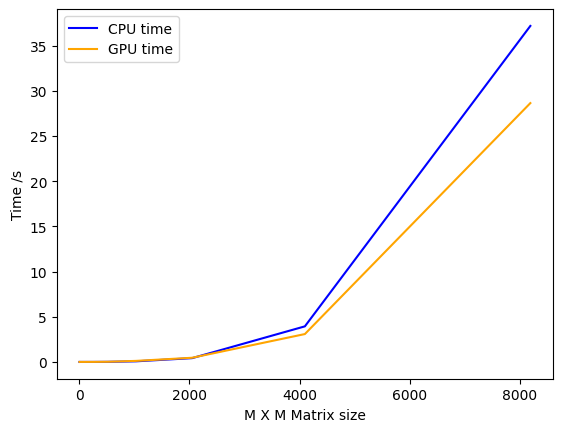

In [10]:
def get_size_timings(size):
    assert size < 14, "Don't overdo it! max 8096 without crashes. Use size 13."

    cpu_timings = []
    gpu_timings = []
    matrices = []
    for n in range(size + 1):
        matrix_size = 2**n
        print(matrix_size)
        A = np.random.random((matrix_size, matrix_size))
        B = np.random.random((matrix_size, matrix_size))

        start_time_gpu = time.time()
        result_gpu = multiply_on_gpu(A, B)
        time_elapsed_gpu = time.time() - start_time_gpu

        start_time_cpu = time.time()
        result_cpu = multiply_on_cpu(A, B)
        time_elapsed_cpu = time.time() - start_time_cpu

        cpu_timings.append(time_elapsed_cpu)
        gpu_timings.append(time_elapsed_gpu)
        matrices.append(matrix_size)

    return matrices, cpu_timings, gpu_timings

import matplotlib.pyplot as plt
#### HERE SET THE SIZE OF THE PROBLEM ####
size = 13 # 2 ** size x 2 ** size M X M matrices
###########################################
matrices, cpu_timings, gpu_timings =  get_size_timings(size)
plt.plot(matrices, cpu_timings, color="blue", label="CPU time")
plt.plot(matrices, gpu_timings, color="orange", label="GPU time")
plt.ylabel('Time /s')
plt.xlabel('M X M Matrix size')
plt.legend()
plt.show()

The not-so-sophisticated approach is starting to be beneficial at M > 2048.

Let's see how more GPU-oriented methods do in such calculations.

# Improved matrix multiplication
The following example shows how shared memory can be used when performing matrix multiplication.

In this example, each thread block is responsible for computing a square sub-matrix of C and each thread for computing an element of the sub-matrix. The sub-matrix is equal to the product of a square sub-matrix of A (sA) and a square sub-matrix of B (sB). In order to fit into the device resources, the two input matrices are divided into as many square sub-matrices of dimension TPB as necessary, and the result computed as the sum of the products of these square sub-matrices.

Each product is performed by first loading sA and sB from global memory to shared memory, with one thread loading each element of each sub-matrix. Once sA and sB have been loaded, each thread accumulates the result into a register (tmp). Once all the products have been calculated, the results are written to the matrix C in global memory.

By blocking the computation this way, we can reduce the number of global memory accesses since A is now only read B.shape[1] / TPB times and B is read A.shape[0] / TPB times.

![picture](https://nyu-cds.github.io/python-numba/fig/05-matmulshared.png)



In [6]:
from __future__ import division
from numba import cuda, float32
import numpy
import math

# Controls threads per block and shared memory usage.
# The computation will be done on blocks of TPBxTPB elements.
TPB = 32

@cuda.jit
def fast_matmul(A, B, C):
    """
    Perform matrix multiplication of C = A * B
    Each thread computes one element of the result matrix C
    """

    # Define an array in the shared memory
    # The size and type of the arrays must be known at compile time
    sA = cuda.shared.array(shape=(TPB, TPB), dtype=float32)
    sB = cuda.shared.array(shape=(TPB, TPB), dtype=float32)

    x, y = cuda.grid(2)

    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y

    if x >= C.shape[0] and y >= C.shape[1]:
        # Quit if (x, y) is outside of valid C boundary
        return

    # Each thread computes one element in the result matrix.
    # The dot product is chunked into dot products of TPB-long vectors.
    tmp = 0.
    for i in range(int(A.shape[1] / TPB)):
        # Preload data into shared memory
        sA[tx, ty] = A[x, ty + i * TPB]
        sB[tx, ty] = B[tx + i * TPB, y]

        # Wait until all threads finish preloading
        cuda.syncthreads()

        # Computes partial product on the shared memory
        for j in range(TPB):
            tmp += sA[tx, j] * sB[j, ty]

        # Wait until all threads finish computing
        cuda.syncthreads()

    C[x, y] = tmp

# The data array
n = 100
A = numpy.full((TPB*n, TPB*n), 3, numpy.float) # [TPB*n x TPB*n] matrix containing all 3's
B = numpy.full((TPB*n, TPB*n), 4, numpy.float) # [TPB*n x TPB*n] matrix containing all 4's

A_global_mem = cuda.to_device(A)
B_global_mem = cuda.to_device(B)
C_global_mem = cuda.device_array((TPB*n, TPB*n)) # [TPB*n x TPB*n] matrix result

# Configure the blocks
threadsperblock = (TPB, TPB)
blockspergrid_x = int(math.ceil(A.shape[0] / threadsperblock[1]))
blockspergrid_y = int(math.ceil(B.shape[1] / threadsperblock[0]))
blockspergrid = (blockspergrid_x, blockspergrid_y)

<ipython-input-6-929d79759f1a>:53: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  A = numpy.full((TPB*n, TPB*n), 3, numpy.float) # [TPB*n x TPB*n] matrix containing all 3's
<ipython-input-6-929d79759f1a>:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  B = numpy.full((TPB*n, TPB*n), 4, numpy.float) # [TPB*n x TPB*n] matrix containing all 

In [7]:
start_time_cpu = time.time()
result_cpu = multiply_on_cpu(A, B)
end_time_cpu = time.time() - start_time_cpu
print("Time from CPU-optimised:\n", end_time_cpu)

start_time_gpu = time.time()
result_gpu = multiply_on_gpu(A, B)
end_time_gpu = time.time() - start_time_gpu
print("Time from GPU non-optimised:\n", end_time_gpu)

# Start the kernel
start_gpu_opt = time.time()
fast_matmul[blockspergrid, threadsperblock](A_global_mem, B_global_mem, C_global_mem)
res = C_global_mem.copy_to_host()
end_time_gpu_opt = time.time() - start_gpu_opt
# This might be higher on first run - the compilation time is included
print("Result from GPU-optimised:\n", end_time_gpu_opt)



Time from CPU-optimised:
 2.666105270385742
Time from GPU non-optimised:
 1.6712682247161865
Result from GPU-optimised:
 1.9634122848510742


In [8]:
def get_size_timings_cuda(size):
    assert size < 14, "Don't overdo it! max 8096 without crashes. Use max size 13."

    elapsed = []
    matrices = []
    for n in range(1, size+1):
        matrix_size = 2**n
        print(matrix_size)

        # The data array
        A = np.random.random((matrix_size, matrix_size))
        B = np.random.random((matrix_size, matrix_size))


        A_global_mem = cuda.to_device(A)
        B_global_mem = cuda.to_device(B)
        C_global_mem = cuda.device_array((matrix_size, matrix_size))

        # Configure the blocks
        TPB = 32
        threadsperblock = (TPB, TPB)
        blockspergrid_x = int(math.ceil(A.shape[0] / threadsperblock[1]))
        blockspergrid_y = int(math.ceil(B.shape[1] / threadsperblock[0]))
        blockspergrid = (blockspergrid_x, blockspergrid_y)

        start = time.time()
        fast_matmul[blockspergrid, threadsperblock](A_global_mem, B_global_mem, C_global_mem)
        res = C_global_mem.copy_to_host()
        end = time.time() - start
        elapsed.append(end)
        matrices.append(matrix_size)

    return  matrices, elapsed


2
4
8
16
32
64
128
256
512
1024
2048


/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 4 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 16 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 64 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


4096


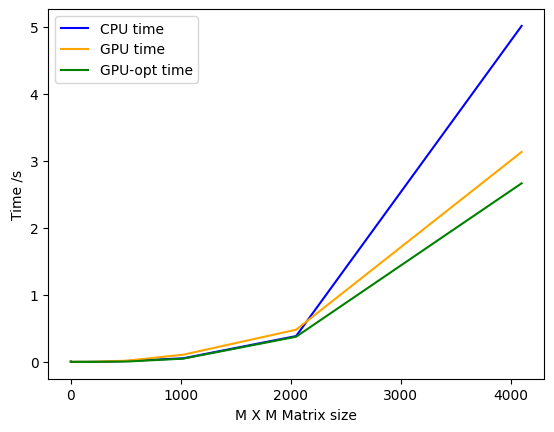

In [9]:
plt.plot(matrices, cpu_timings, color="blue", label="CPU time")
plt.plot(matrices, gpu_timings, color="orange", label="GPU time")
plt.plot(*get_size_timings_cuda(size), color="green", label="GPU-opt time")
plt.ylabel('Time /s')
plt.xlabel('M X M Matrix size')
plt.legend()
plt.show()